In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm.auto import tqdm 
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

import torch
import torch.nn.functional as F
from torch.utils import data
from torchinfo import summary
import torch.nn as nn
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lobster-data/GOOG_2012-06-21_34200000_57600000_orderbook_10.csv
/kaggle/input/amazon-order-book-data/AMZN_2012-06-21_34200000_57600000_orderbook_10.csv
/kaggle/input/lobsterdataset/AAPL_2012-06-21_34200000_57600000_orderbook_10.csv


The aim of the project is to develop an algorithmic trading strategy, using a forecast of the mid-price direction in the next 10-tick horizon for the Amazon Order Book. The DeepLOB model https://github.com/zcakhaa/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books is used on sample LOBSTER data https://lobsterdata.com/info/DataSamples.php.

The mean spread in training is 0.13086169313581555


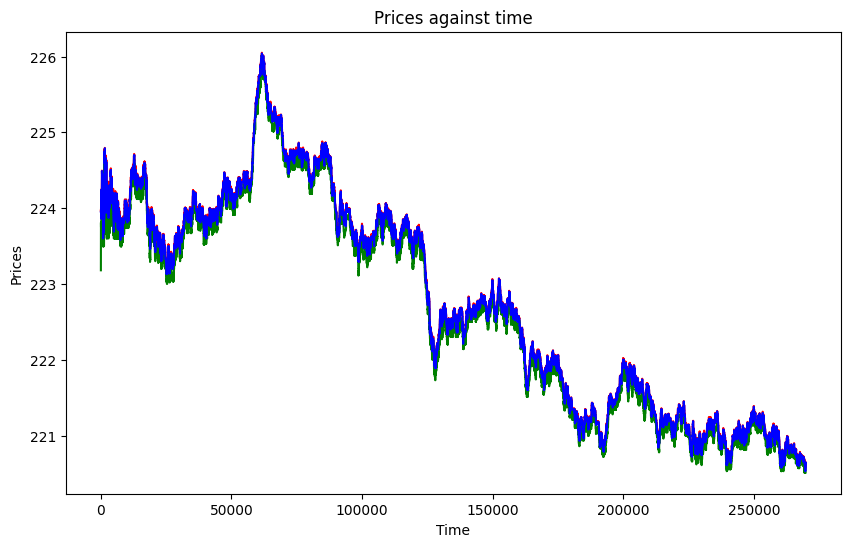

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


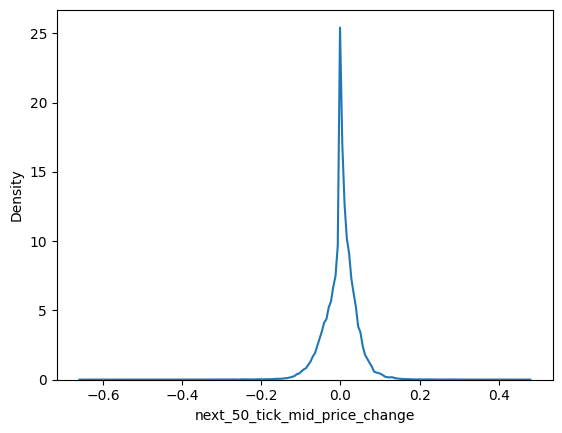

11057618


,ask_price_1,ask_size_1,bid_price_1,bid_size_1,ask_price_2,ask_size_2,bid_price_2,bid_size_2,ask_price_3,ask_size_3,...,bid_size_8,ask_price_9,ask_size_9,bid_price_9,bid_size_9,ask_price_10,ask_size_10,bid_price_10,bid_size_10,Target
269693,220.64,160,220.54,100,220.65,699,220.53,100,220.66,100,...,300,220.75,866,220.46,104,220.76,100,220.45,100,1
269694,220.64,160,220.54,100,220.65,699,220.53,100,220.66,100,...,300,220.75,866,220.46,104,220.76,100,220.45,100,1
269695,220.64,160,220.54,100,220.65,699,220.53,100,220.66,100,...,300,220.75,100,220.46,104,220.76,100,220.45,100,1
269696,220.64,160,220.54,100,220.65,1465,220.53,100,220.66,100,...,300,220.75,100,220.46,104,220.76,100,220.45,100,1
269697,220.64,160,220.54,100,220.65,1465,220.53,100,220.66,100,...,200,220.75,100,220.46,104,220.76,100,220.45,100,1


In [2]:
Training = True
column_names = []
for i in range(1, 11):
    column_names.append(f'ask_price_{i}')
    column_names.append(f'ask_size_{i}')
    column_names.append(f'bid_price_{i}')
    column_names.append(f'bid_size_{i}')
    
df = pd.read_csv("/kaggle/input/amazon-order-book-data/AMZN_2012-06-21_34200000_57600000_orderbook_10.csv", names = column_names, header = None)



for i in range(1,11):
    df[f"ask_price_{i}"] /= 10000
    df[f"bid_price_{i}"] /= 10000

# Spread in training
spread = (df['ask_price_1'] - df['bid_price_1']).mean()
print(f"The mean spread in training is {spread}")

df['mid_price'] = (df["ask_price_1"] + df["ask_price_2"]) / 2

import matplotlib.pyplot as plt
plt.figure(figsize = (10,6))
plt.plot(df["mid_price"], color = 'r', label = 'Best Mid price')
plt.plot(df["bid_price_1"], color = 'g', label = 'Best Bid price')
plt.plot(df['ask_price_1'], color = 'b', label = 'Best Ask price')
plt.title("Prices against time")
plt.xlabel('Time')
plt.ylabel('Prices')
plt.show()

df['next_50_tick_mid_price_change'] = (df['mid_price'] - df['mid_price'].shift(-50)) 


def category(x, threshold = 0.02):
    if x > threshold:
        return 0
    elif -threshold <= x <= threshold:
        return 1
    else:
        return 2

df = df.dropna()
# Probability plot of next_50_tick_mid_price_change
sns.kdeplot(data=df['next_50_tick_mid_price_change'])
# Show plot
plt.show()


df['Target'] = df['next_50_tick_mid_price_change'].apply(category)

df = df.drop(columns = ['mid_price','next_50_tick_mid_price_change'])
    
print(df.size)
df.tail()

Text(0, 0.5, 'Frequency')

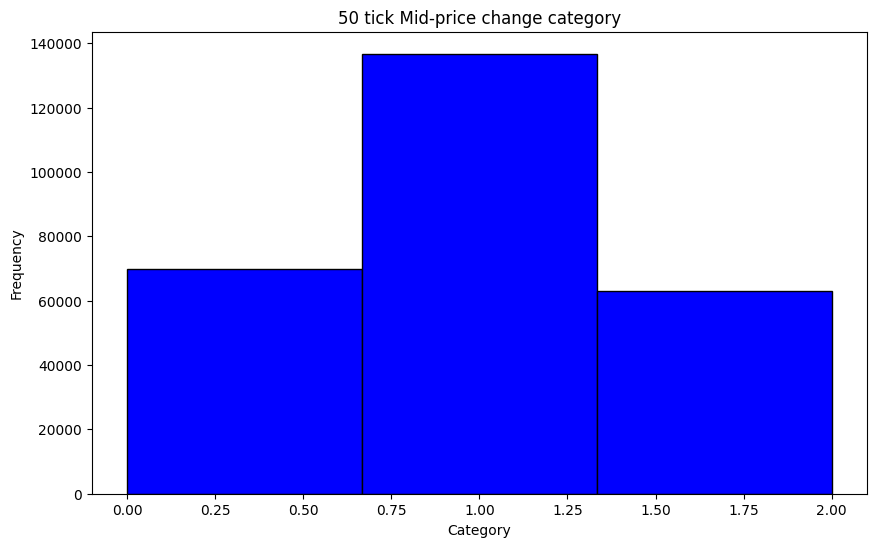

In [3]:
plt.figure(figsize = (10,6))
plt.hist(df['Target'], bins = 3, color = 'blue', edgecolor = 'black')
plt.title('50 tick Mid-price change category')
plt.xlabel('Category')
plt.ylabel('Frequency')

In [4]:
# Split into training, validation and testing
train_test_split_index = int(0.9 * len(df))
X = df[:train_test_split_index]
df_test = df[train_test_split_index:]
train_val_split_index = int(0.95 * len(X))
df_train = X[:train_val_split_index]
df_val = X[train_val_split_index:]
df_train.size, df_val.size, df_test.size

(9454231, 497617, 1105770)

In [5]:
from torch.utils.data import Dataset, DataLoader
# Construct dataclasses to split the data into (temporal x spatial) batch

def prepare_x_data(data):
    df = data.iloc[:, :-1]
    return np.array(df)

def get_target(data):
    df = data.iloc[:, -1:]
    return np.array(df)

def make_2D_batches(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)

    dY = np.array(Y)

    dataY = dY[T - 1:N]

    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]

    return dataX, dataY


    
# Create the dataset class
class Data(Dataset):
    def __init__(self, data, num_classes, T):
        self.T = T
        self.num_classes = num_classes
        x = prepare_x_data(data)
        y = get_target(data)
        x,y = make_2D_batches(x,y, T)
        self.length = len(x)
        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x,1)
        self.y = torch.from_numpy(y).squeeze()

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [6]:
# Transfrom the data into datasets and place in dataloader
train_dataset = Data(df_train, num_classes = 3, T = 100)
val_dataset = Data(df_val, num_classes = 3, T = 100)
test_dataset= Data(df_test, num_classes = 3, T = 100)

BATCH_SIZE = 32

train_dataloader =  DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

train_dataset.x.shape, train_dataset.y.shape

(torch.Size([230492, 1, 100, 40]), torch.Size([230492]))

In [7]:
class deeplob(nn.Module):
    def __init__(self, y_len):
        super().__init__()
        self.y_len = y_len
        
        # convolution blocks
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.LeakyReLU(negative_slope=0.01),
            #nn.Dropout(0.2),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            #nn.Dropout(0.2),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            #nn.Dropout(0.2),
            nn.BatchNorm2d(32),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            #nn.Dropout(0.2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            #nn.Dropout(0.2),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            #nn.Dropout(0.2),
            nn.BatchNorm2d(32),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,10)),
            nn.LeakyReLU(negative_slope=0.01),
            #nn.Dropout(0.2),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            #nn.Dropout(0.2),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            #nn.Dropout(0.2),
            nn.BatchNorm2d(32),
        )
        
        # inception moduels
        self.inp1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp3 = nn.Sequential(
            nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        
        # lstm layers
        self.lstm = nn.LSTM(input_size=192, hidden_size=64, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(64, self.y_len)

    def forward(self, x):
        # h0: (number of hidden layers, batch size, hidden size)
        h0 = torch.zeros(1, x.size(0), 64).to(device)
        c0 = torch.zeros(1, x.size(0), 64).to(device)
    
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x_inp1 = self.inp1(x)
        x_inp2 = self.inp2(x)
        x_inp3 = self.inp3(x)  
        
        x = torch.cat((x_inp1, x_inp2, x_inp3), dim=1)
        

        x = x.permute(0, 2, 1, 3)
        x = torch.reshape(x, (-1, x.shape[1], x.shape[2]))
        
        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = self.fc1(x)
        forecast_y = torch.softmax(x, dim=1)
        
        return forecast_y

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = deeplob(y_len = train_dataset.num_classes)
model.to(device)

deeplob(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): Tanh()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): Tanh()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(4, 1), stride

In [9]:
summary(model, (1, 1, 100, 40))

Layer (type:depth-idx)                   Output Shape              Param #
deeplob                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 32, 94, 20]           --
│    └─Conv2d: 2-1                       [1, 32, 100, 20]          96
│    └─LeakyReLU: 2-2                    [1, 32, 100, 20]          --
│    └─BatchNorm2d: 2-3                  [1, 32, 100, 20]          64
│    └─Conv2d: 2-4                       [1, 32, 97, 20]           4,128
│    └─LeakyReLU: 2-5                    [1, 32, 97, 20]           --
│    └─BatchNorm2d: 2-6                  [1, 32, 97, 20]           64
│    └─Conv2d: 2-7                       [1, 32, 94, 20]           4,128
│    └─LeakyReLU: 2-8                    [1, 32, 94, 20]           --
│    └─BatchNorm2d: 2-9                  [1, 32, 94, 20]           64
├─Sequential: 1-2                        [1, 32, 88, 10]           --
│    └─Conv2d: 2-10                      [1, 32, 94, 10]           2,080
│    └

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=6e-05, betas = (0.9, 0.95))

In [11]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0

    for it in tqdm(range(epochs)):
        
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in tqdm(train_loader):
            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
            # print("inputs.shape:", inputs.shape)
            # zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            # print("about to get model output")
            outputs = model(inputs)
            # print("done getting model output")
            # print("outputs.shape:", outputs.shape, "targets.shape:", targets.shape)
            loss = criterion(outputs, targets)
            # Backward and optimize
            # print("about to optimize")
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading
    
        model.eval()
        test_loss = []
        for inputs, targets in tqdm(test_loader):
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)      
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        if test_loss < best_test_loss:
            torch.save(model, './best_val_model_pytorch')
            best_test_loss = test_loss
            best_test_epoch = it
            print('model saved')

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch + 1}')

    return train_losses, test_losses

In [12]:
if Training:
    train_losses, val_losses = batch_gd(model, criterion, optimizer, 
                                        train_dataloader, val_dataloader, epochs=15)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/7203 [00:00<?, ?it/s]

  0%|          | 0/377 [00:00<?, ?it/s]

model saved
Epoch 1/15, Train Loss: 1.0114,           Validation Loss: 1.0548, Duration: 0:01:29.993078, Best Val Epoch: 1


  0%|          | 0/7203 [00:00<?, ?it/s]

  0%|          | 0/377 [00:00<?, ?it/s]

Epoch 2/15, Train Loss: 0.9473,           Validation Loss: 1.0576, Duration: 0:01:28.933644, Best Val Epoch: 1


  0%|          | 0/7203 [00:00<?, ?it/s]

  0%|          | 0/377 [00:00<?, ?it/s]

Epoch 3/15, Train Loss: 0.9002,           Validation Loss: 1.0876, Duration: 0:01:28.595532, Best Val Epoch: 1


  0%|          | 0/7203 [00:00<?, ?it/s]

  0%|          | 0/377 [00:00<?, ?it/s]

Epoch 4/15, Train Loss: 0.8655,           Validation Loss: 1.0870, Duration: 0:01:28.469554, Best Val Epoch: 1


  0%|          | 0/7203 [00:00<?, ?it/s]

  0%|          | 0/377 [00:00<?, ?it/s]

Epoch 5/15, Train Loss: 0.8396,           Validation Loss: 1.0829, Duration: 0:01:28.583493, Best Val Epoch: 1


  0%|          | 0/7203 [00:00<?, ?it/s]

  0%|          | 0/377 [00:00<?, ?it/s]

Epoch 6/15, Train Loss: 0.8185,           Validation Loss: 1.0862, Duration: 0:01:28.923805, Best Val Epoch: 1


  0%|          | 0/7203 [00:00<?, ?it/s]

  0%|          | 0/377 [00:00<?, ?it/s]

Epoch 7/15, Train Loss: 0.8015,           Validation Loss: 1.0813, Duration: 0:01:28.094308, Best Val Epoch: 1


  0%|          | 0/7203 [00:00<?, ?it/s]

  0%|          | 0/377 [00:00<?, ?it/s]

Epoch 8/15, Train Loss: 0.7876,           Validation Loss: 1.1149, Duration: 0:01:28.398362, Best Val Epoch: 1


  0%|          | 0/7203 [00:00<?, ?it/s]

  0%|          | 0/377 [00:00<?, ?it/s]

Epoch 9/15, Train Loss: 0.7747,           Validation Loss: 1.1127, Duration: 0:01:28.846137, Best Val Epoch: 1


  0%|          | 0/7203 [00:00<?, ?it/s]

  0%|          | 0/377 [00:00<?, ?it/s]

Epoch 10/15, Train Loss: 0.7638,           Validation Loss: 1.1152, Duration: 0:01:28.186940, Best Val Epoch: 1


  0%|          | 0/7203 [00:00<?, ?it/s]

  0%|          | 0/377 [00:00<?, ?it/s]

Epoch 11/15, Train Loss: 0.7551,           Validation Loss: 1.1096, Duration: 0:01:29.901261, Best Val Epoch: 1


  0%|          | 0/7203 [00:00<?, ?it/s]

  0%|          | 0/377 [00:00<?, ?it/s]

Epoch 12/15, Train Loss: 0.7477,           Validation Loss: 1.1181, Duration: 0:01:28.470835, Best Val Epoch: 1


  0%|          | 0/7203 [00:00<?, ?it/s]

  0%|          | 0/377 [00:00<?, ?it/s]

Epoch 13/15, Train Loss: 0.7403,           Validation Loss: 1.1054, Duration: 0:01:28.197899, Best Val Epoch: 1


  0%|          | 0/7203 [00:00<?, ?it/s]

  0%|          | 0/377 [00:00<?, ?it/s]

Epoch 14/15, Train Loss: 0.7328,           Validation Loss: 1.0946, Duration: 0:01:28.966478, Best Val Epoch: 1


  0%|          | 0/7203 [00:00<?, ?it/s]

  0%|          | 0/377 [00:00<?, ?it/s]

Epoch 15/15, Train Loss: 0.7284,           Validation Loss: 1.1223, Duration: 0:01:28.856716, Best Val Epoch: 1


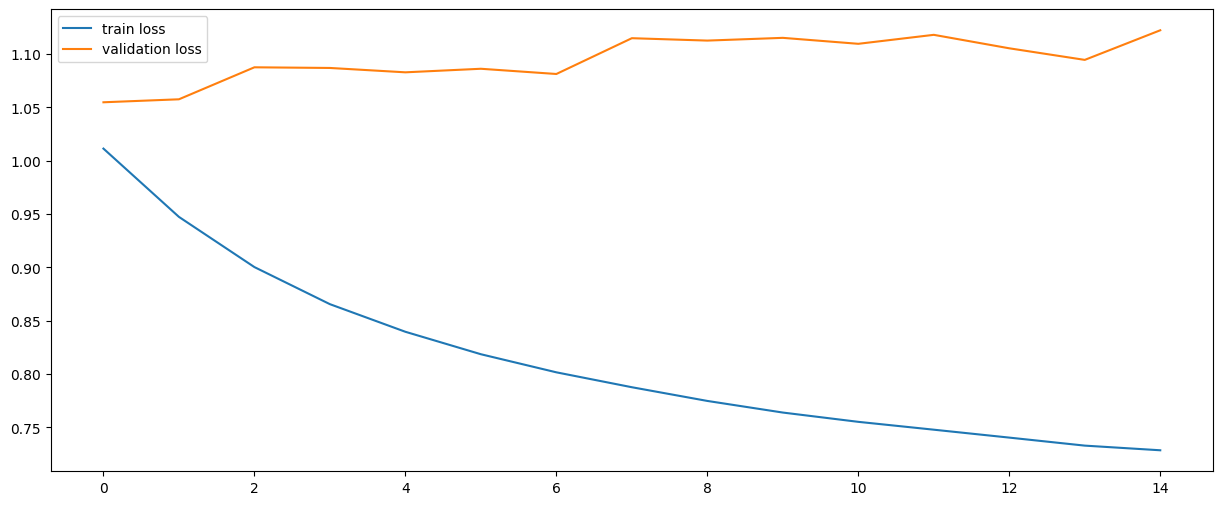

In [13]:
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

In [14]:
# model = torch.load('best_val_model_pytorch')
all_targets = []
all_predictions = []

for inputs, targets in tqdm(train_dataloader):
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)  

  0%|          | 0/7203 [00:00<?, ?it/s]

accuracy_score_train: 0.811594328653489


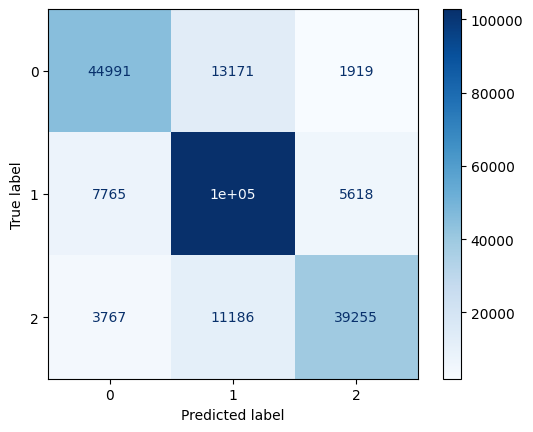

Matthews Correlation Coefficient (Multi-Class): 0.6934193209577936


In [15]:
print('accuracy_score_train:', accuracy_score(all_targets, all_predictions))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(all_targets, all_predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap=plt.cm.Blues)
plt.show()
# Mathews Correlation coefficient
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(all_targets, all_predictions)
print(f"Matthews Correlation Coefficient (Multi-Class): {mcc}")

In [16]:
# model = torch.load('best_val_model_pytorch')
all_targets = []
all_predictions = []

for inputs, targets in tqdm(test_dataloader):
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)  

  0%|          | 0/840 [00:00<?, ?it/s]

accuracy_score_test: 0.42945926835622045


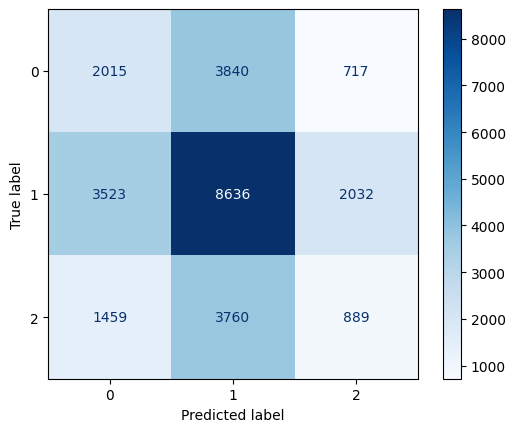

Matthews Correlation Coefficient (Multi-Class): 0.027490910225996243


In [17]:
print('accuracy_score_test:', accuracy_score(all_targets, all_predictions))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(all_targets, all_predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap=plt.cm.Blues)
plt.show()
# Mathews Correlation coefficient
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(all_targets, all_predictions)
print(f"Matthews Correlation Coefficient (Multi-Class): {mcc}")

In [18]:
# Prepare the whole dataset with predictions
data = Data(df, num_classes = 3, T = 100)
data_dataloader = DataLoader(data, batch_size = BATCH_SIZE, shuffle = False)
all_targets = []
all_predictions = []
for inputs, targets in tqdm(data_dataloader):
    inputs, targets = inputs.to(device, dtype=torch.float32), targets.to(device, dtype=torch.int32)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    all_targets.append(targets.cpu().numpy())
    all_predictions.append(targets.cpu().numpy())

all_targets = np.concatenate(all_targets)
all_predictions = np.concatenate(all_predictions)



  0%|          | 0/8425 [00:00<?, ?it/s]

In [19]:
# Adding 100 missing None values for the first 100 ticks -> first prediction comes after 100 ticks
# We also assume that we can buy always at the best ask price and sell at the best bid_price
combined_values = np.concatenate([100 * [None], all_predictions])

df['Prediction'] = pd.Series(combined_values)

# Display the first few rows
df = df[['ask_price_1', 'bid_price_1', 'Prediction']]
df = df.dropna()
df.tail(50)

,ask_price_1,bid_price_1,Prediction
269648,220.65,220.60,1
269649,220.65,220.60,1
269650,220.65,220.60,1
269651,220.65,220.60,1
269652,220.65,220.60,1
269653,220.65,220.60,1
269654,220.65,220.60,1
269655,220.65,220.60,1
269656,220.63,220.60,1
269657,220.63,220.60,1


A profitable strategy needs to be accurate on predicting changes above the spread. Otherwise we incur a loss even with assuming profitable trades. Liquid markets enable more flexibility with the threshold change. The threshold choosing mid-price movements for stable/up/down classes stabilizes class imbalance. The DeepLOB model overfits possibly due to lack of volume of training data (only using sample data).